Status: complete

Conclusion: SPRITE zero stock unannealed plate (aliquot 2) is contaminated, and the contamination looks identical to that present in Andrew's 45 uM annealed plate (see previous analysis, 20240112.ipynb)
- Only concern with the analysis itself: not sure why the complexity measured by Tapestation is 3 orders of magnitude greater than estimated by sequencing.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [48]:
# Python Standard Library modules
import gzip
import itertools
import os
import re
import subprocess
import sys

# Basic SciPy packages
import numpy as np
import scipy
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.graph_objects as go
import plotly.express as px

from tqdm.auto import tqdm

# Custom modules
sys.path.append('../scripts')
import string_distances
import parse_barcodes
from helpers import fastq_parse

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-01-29T16:00:28.398960-08:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 3.10.0-1160.53.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

conda environment: py3

sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
matplotlib: 3.7.2
pandas    : 2.0.2
scipy     : 1.11.1
numpy     : 1.23.5
plotly    : 5.15.0
seaborn   : 0.12.2
re        : 2.2.1



In [4]:
%%bash
splitcode --version

splitcode, version 0.29.1


In [5]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20240124')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20240124')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20240124')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20240124')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [6]:
ROUNDS = ['R1', 'R2', 'R3', 'Y']

# Data

- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1V8XqNpregIKxeOkKoKZkjcBYAG0Le6keFXRmN9onmxc)
- [Library sheet](https://docs.google.com/spreadsheets/d/1aD9_pRSCNiRh3eJIpBlkJjRPikfE5cJUSjV16kvducQ)
- [Benchling notebook: 2024-01-18 Tag Plate Contamination, v3](https://benchling.com/s/etr-0kEaLIIMFTjHJbNXzjpb)

In [7]:
path_df_data = os.path.join(DIR_RESULTS, 'sample_info.csv')
if not os.path.exists(path_df_data) or True:
    regex_fastq_files = re.compile((
        r'(?P<filename>(?P<sample>Ben(?P<well>[^_]+))_.*R(?P<read>1|2).fastq.gz)'))
    
    files_fastq = sorted([file for file in os.listdir(DIR_DATA) if file.endswith('.fastq.gz')])
    df_data = pd.DataFrame([
        regex_fastq_files.match(file).groupdict() for file in files_fastq]) \
        .astype(dict(read=int, well=int))
    
    popen_counts = dict()
    for sample, group in df_data.groupby('sample'):
        filename = group.loc[group['read'] == 1, 'filename'].item()
        cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
        popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    
    df_data['n_reads'] = int(0)
    for sample, popen in popen_counts.items():
        count, err = popen.communicate()
        assert err is None and popen.returncode == 0
        df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())
    
    path_library_info = os.path.join(DIR_DATA, '2024-01-21 Tag Plate Contamination Test, v3 Libraries.csv')
    df_library_info = (
        pd.read_csv(path_library_info, usecols=['Sample', 'Peak Complexity'])
        .rename(columns={'Sample': 'sample', 'Peak Complexity': 'Complexity (Tapestation)'})
        .pipe(lambda df: df.assign(sample=df['sample'].str.replace('barcode_', 'Ben')))
    )
    
    # from the library sheet, linked above
    df_data = (
        df_data
        .merge(df_library_info, how='left')
        .sort_values(['sample', 'read'])
        .reset_index(drop=True)
        .sort_values(['well', 'read'])
    )
    df_data.to_csv(path_df_data, index=False)
else:
    df_data = pd.read_csv(path_df_data, index_col=False)

In [8]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)
display(df_data)

Total number of paired reads: 7607885


filename sample  well  read  n_reads  Complexity (Tapestation)
0    Ben1_R1.fastq.gz   Ben1     1     1   207389              5.160000e+09
1    Ben1_R2.fastq.gz   Ben1     1     2   207389              5.160000e+09
22   Ben2_R1.fastq.gz   Ben2     2     1   321482              8.690000e+09
23   Ben2_R2.fastq.gz   Ben2     2     2   321482              8.690000e+09
34   Ben3_R1.fastq.gz   Ben3     3     1   296216              8.020000e+09
35   Ben3_R2.fastq.gz   Ben3     3     2   296216              8.020000e+09
36   Ben4_R1.fastq.gz   Ben4     4     1   221216              6.130000e+09
37   Ben4_R2.fastq.gz   Ben4     4     2   221216              6.130000e+09
38   Ben5_R1.fastq.gz   Ben5     5     1   444782              1.190000e+10
39   Ben5_R2.fastq.gz   Ben5     5     2   444782              1.190000e+10
40   Ben6_R1.fastq.gz   Ben6     6     1   317009              9.370000e+09
41   Ben6_R2.fastq.gz   Ben6     6     2   317009              9.370000e+09
42   Ben7_R1.fastq.gz   Ben7     7     1   430530              1.220000e+10
43   Ben7_R2.fastq.gz   Ben7     7     2   430530              1.220000e+10
44   Ben8_R1.fastq.gz   Ben8     8     1   120801              3.730000e+09
45   Ben8_R2.fastq.gz   Ben8     8     2   120801              3.730000e+09
46   Ben9_R1.fastq.gz   Ben9     9     1   564898              1.710000e+10
47   Ben9_R2.fastq.gz   Ben9     9     2   564898              1.710000e+10
2   Ben10_R1.fastq.gz  Ben10    10     1   564141              1.690000e+10
3   Ben10_R2.fastq.gz  Ben10    10     2   564141              1.690000e+10
4   Ben11_R1.fastq.gz  Ben11    11     1   109566              2.720000e+09
5   Ben11_R2.fastq.gz  Ben11    11     2   109566              2.720000e+09
6   Ben12_R1.fastq.gz  Ben12    12     1    72634              2.400000e+09
7   Ben12_R2.fastq.gz  Ben12    12     2    72634              2.400000e+09
8   Ben13_R1.fastq.gz  Ben13    13     1   292576              1.000000e+10
9   Ben13_R2.fastq.gz  Ben13    13     2   292576              1.000000e+10
10  Ben14_R1.fastq.gz  Ben14    14     1   385397              1.060000e+10
11  Ben14_R2.fastq.gz  Ben14    14     2   385397              1.060000e+10
12  Ben15_R1.fastq.gz  Ben15    15     1   325050              1.010000e+10
13  Ben15_R2.fastq.gz  Ben15    15     2   325050              1.010000e+10
14  Ben16_R1.fastq.gz  Ben16    16     1   289785              8.020000e+09
15  Ben16_R2.fastq.gz  Ben16    16     2   289785              8.020000e+09
16  Ben17_R1.fastq.gz  Ben17    17     1   392764              9.710000e+09
17  Ben17_R2.fastq.gz  Ben17    17     2   392764              9.710000e+09
18  Ben18_R1.fastq.gz  Ben18    18     1   343544              1.140000e+10
19  Ben18_R2.fastq.gz  Ben18    18     2   343544              1.140000e+10
20  Ben19_R1.fastq.gz  Ben19    19     1   219573              6.440000e+09
21  Ben19_R2.fastq.gz  Ben19    19     2   219573              6.440000e+09
24  Ben20_R1.fastq.gz  Ben20    20     1   103969              3.410000e+09
25  Ben20_R2.fastq.gz  Ben20    20     2   103969              3.410000e+09
26  Ben21_R1.fastq.gz  Ben21    21     1   340413              1.000000e+10
27  Ben21_R2.fastq.gz  Ben21    21     2   340413              1.000000e+10
28  Ben22_R1.fastq.gz  Ben22    22     1   456715              1.230000e+10
29  Ben22_R2.fastq.gz  Ben22    22     2   456715              1.230000e+10
30  Ben23_R1.fastq.gz  Ben23    23     1   441868              1.020000e+10
31  Ben23_R2.fastq.gz  Ben23    23     2   441868              1.020000e+10
32  Ben24_R1.fastq.gz  Ben24    24     1   345567              9.670000e+09
33  Ben24_R2.fastq.gz  Ben24    24     2   345567              9.670000e+09

## Check sequencing depth

Linear relationship between Tapestation-estimated library complexity and number of reads obtained.

In [9]:
fig = px.scatter(
    df_data.loc[df_data['read'] == 1],
    x='Complexity (Tapestation)',
    y='n_reads',
    color='sample',
    trendline='ols',
    trendline_scope='overall'
)

# set height to ensure that all samples are shown in legend without need for scrolling
fig.update_layout(height=600, width=800, margin=dict(l=10, r=10, b=10, t=20))
fig.show()

# Alternative non-interactive plot using seaborn
# g = sns.relplot(
#     kind='scatter',
#     data=df_data.loc[df_data['read'] == 1],
#     x='Complexity (Tapestation)',
#     y='n_reads',
#     hue='sample',
#     col='quench',
#     facet_kws=dict(sharex=False, sharey=False)
# )

# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
- Read 2: near total duplication from each sample, since all barcodes from the same nucleus should have the same R1, R2, R3, and NYLigOdd tags

Gross observations: lots of contamination

In [10]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    conda activate chipdip
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

# Count barcodes

Expected read structures (see also Benchling DNA sequence: [Oligo (PC50_12merUMI) + R1-R3 + NYLigOdd PCR Product (2Puni + 2Pbc)](https://benchling.com/s/seq-uec4dPutBQPpgn6aNbXV))

| Component                                 | Length | R1 coordinates | R2 coordinates |
| ----------------------------------------- | ------ | -------------- | -------------- |
| 2Puni adapter, Illumina universal adapter | 11     | n/a            | 97-100:108-111 |
| Oligo UMI                                 | 12     | 0:12           | 85-88:97-100   |
| LigEven / Even overhang                   | 7      | 12:19          | 78-81:85-88    |
| R1 unique sequence                        | 16     | 19:35          | 62-65:78-81    |
| LigR1 / R1 overhang                       | 7      | 35:42          | 55-58:62-65    |
| R2 unique sequence                        | 16     | 42:58          | 39-42:55-58    |
| LigR2 / R2 overhang                       | 7      | 58:65          | 32-35:39-42    |
| R3 unique sequence                        | 16     | 65:81          | 16-19:32-35    |
| LigR3 / R3 overhang                       | 7      | 81:88          | 9-12:16-19     |
| NYLigOddStg unique sequence               | 9-12   | 88:97-100      | 0:9-12         |
| 2Pbc adapter, Illumina universal adapter  | 11     | 97-100:108-111 | n/a            |

1. Add barcode and UMI to read name:

   `@read::[LigEven][R1Top_<R1_1>][LigR1][R2Top_<R2_1>][LigR2][R3Top_<R3_1>][LigR3][NYLigOddStgTop_<Y_1>][2Pbc][NYStgBot_<Y_2>][R3][R3Bot_<R3_2>][R2][R2Bot_<R2_2>][R1][R1Bot_<R1_2>][Even][2Puni] RX:Z:<umi1>-<umi2>`

2. Calculate barcode counts

## Tag identification by splitcode

In [11]:
path_config = os.path.join(DIR_AUX, 'splitcode_config.tsv')

In [64]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_PROJECT} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_PROJECT="$3"
PATH_CONFIG="$4"

PATH_SBATCH="$DIR_PROJECT/scripts/splitcode2.sbatch"

for PATH_R1 in "$DIR_DATA"/*_R1.fastq.gz; do
    SAMPLE="$(echo "$PATH_R1" | grep -o -E -e 'Ben[0-9]+')"
    PATH_R2="$(ls "${DIR_DATA}/${SAMPLE}"_R2.fastq.gz)"
    PATH_MAPPING="$DIR_PROC/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="$DIR_PROC/summary-${SAMPLE}.json"
    PATH_OUTPUT="$DIR_PROC/read_barcodes-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ]; then

        # submit as SLURM jobs
        PATH_SBATCH_ERROR="$DIR_PROC/sbatch-${SAMPLE}.err"
        PATH_SBATCH_OUT="$DIR_PROC/sbatch-${SAMPLE}.out"
        sbatch --error="$PATH_SBATCH_ERROR" --out="$PATH_SBATCH_OUT" \
            "$PATH_SBATCH" \
            "$PATH_CONFIG" "$PATH_MAPPING" "$PATH_SUMMARY" "$PATH_OUTPUT" "$PATH_R1" "$PATH_R2"

        # run locally
        # splitcode -c "$PATH_CONFIG" \
        #     --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
        #     --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output=/dev/stdout,/dev/null \
        #     "$PATH_R1" "$PATH_R2" |
        # awk '$1 ~ /^>/' |
        # pigz -p 8 > "$PATH_OUTPUT"
        # break
    fi
done

Submitted batch job 39348437
Submitted batch job 39348438
Submitted batch job 39348439
Submitted batch job 39348440
Submitted batch job 39348441
Submitted batch job 39348442
Submitted batch job 39348443
Submitted batch job 39348444
Submitted batch job 39348445
Submitted batch job 39348446
Submitted batch job 39348447
Submitted batch job 39348448
Submitted batch job 39348449
Submitted batch job 39348450
Submitted batch job 39348451
Submitted batch job 39348452
Submitted batch job 39348453
Submitted batch job 39348454
Submitted batch job 39348455
Submitted batch job 39348456
Submitted batch job 39348457
Submitted batch job 39348458
Submitted batch job 39348459
Submitted batch job 39348460


## Compare with exact matching

`@read::[LigEven][R1Top_<R1_1>][LigR1][R2Top_<R2_1>][LigR2][R3Top_<R3_1>][LigR3][NYLigOddStgTop_<Y_1>][2Pbc][NYStgBot_<Y_2>][R3][R3Bot_<R3_2>][R2][R2Bot_<R2_2>][R1][R1Bot_<R1_2>][Even][2Puni] RX:Z:<umi1>-<umi2>`

In [ ]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

In [93]:
read1_structure = (
    ('umi', 12),
    ('ids', 'LigEven'),
    ('groups', 'R1Top'),
    ('ids', 'LigR1'),
    ('groups', 'R2Top'),
    ('ids', 'LigR2'),
    ('groups', 'R3Top'),
    ('ids', 'LigR3'),
    ('groups', 'NYLigOddStgTop'),
    ('ids', '2Pbc')
)

read2_structure = (
    ('groups', 'NYStgBot'),
    ('ids', 'R3'),
    ('groups', 'R3Bot'),
    ('ids', 'R2'),
    ('groups', 'R2Bot'),
    ('ids', 'R1'),
    ('groups', 'R1Bot'),
    ('ids', 'Even'),
    ('umi', 12),
    ('ids', '2Puni')
)

In [89]:
def structure_to_regex(structure, config):
    group_tag_to_id = dict()
    pattern = '^'
    for part, name in structure:
        if part == 'umi':
            pattern += f'(?P<umi>[ATCGN]{{{name}}})'
        elif part == 'ids':
            tags = config.loc[config['ids'] == name, 'tags']
            pattern += f'({"|".join(tags)})'
        elif part == 'groups':
            tags = config.loc[config['groups'] == name, ['tags', 'ids']].drop_duplicates().set_index('tags').squeeze()
            assert tags.index.is_unique
            pattern += f'(?P<__group__{name}>' + '|'.join(tags.index) + ')'
            group_tag_to_id[name] = tags.to_dict()
        else:
            raise ValueError
    return re.compile(pattern), group_tag_to_id

In [90]:
def tag_id_exact(seq, structure, pattern, group_tag_to_id):
    '''
    Args
    - seq: str
    - structure: sequence of 2-tuple
    - config: pd.DataFrame
      - groups
      - ids
      - tags
    '''
    match = pattern.search(seq)
    if not match:
        return None
    match = match.groupdict()
    barcode = []
    for part, name in structure:
        if part == 'ids':
            barcode.append(name)
        elif part == 'groups':
            barcode.append(group_tag_to_id[name][match[f'__group__{name}']])
    return barcode, match['umi']

def paired_tag_extract(seq1, structure1, pattern1, group_tag_to_id1,
                       seq2, structure2, pattern2, group_tag_to_id2):
    '''
    Args
    - seq: str
    - structure: sequence of 2-tuple
    - config: pd.DataFrame
      - groups
      - ids
      - tags
    '''
    result1 = tag_id_exact(seq1, structure1, pattern1, group_tag_to_id1)
    if result1 is None:
        return None
    barcode1, umi1 = result1
    result2 = tag_id_exact(seq2, structure2, pattern2, group_tag_to_id2)
    if result2 is None:
        return None
    barcode2, umi2 = result2
    return ''.join((f'[{name}]' for name in barcode1 + barcode2)) + f' RX:Z:{umi1}-{reverse_complement(umi2)}'

In [44]:
# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

In [ ]:
pattern1, group_tag_to_id1 = structure_to_regex(read1_structure, df_config)
pattern2, group_tag_to_id2 = structure_to_regex(read2_structure, df_config)

for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
    path_r1 = os.path.join(
        DIR_DATA,
        df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == 1), 'filename'].item())
    path_r2 = os.path.join(
        DIR_DATA,
        df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == 2), 'filename'].item())
    with gzip.open(path_r1, 'rt') as f1, \
         gzip.open(path_r2, 'rt') as f2, \
         gzip.open(path_read_barcodes, 'wt') as fout:
        paired_iterator = tqdm(
            zip(fastq_parse(f1), fastq_parse(f2)),
            total=df_data.loc[df_data['sample'] == sample, 'n_reads'].unique()[0])
        for (name1, seq1, _, _), (name2, seq2, _, _) in paired_iterator:
            read_name = name1.split()[0]
            assert read_name == name2.split()[0]
            barcode = paired_tag_extract(
                seq1, read1_structure, pattern1, group_tag_to_id1,
                seq2, read2_structure, pattern2, group_tag_to_id2)
            if barcode is None:
                continue
            fout.write(f'{read_name}::{barcode}\n')

  0%|          | 0/207389 [00:00<?, ?it/s]

  0%|          | 0/321482 [00:00<?, ?it/s]

  0%|          | 0/296216 [00:00<?, ?it/s]

  0%|          | 0/221216 [00:00<?, ?it/s]

  0%|          | 0/444782 [00:00<?, ?it/s]

  0%|          | 0/317009 [00:00<?, ?it/s]

  0%|          | 0/430530 [00:00<?, ?it/s]

  0%|          | 0/120801 [00:00<?, ?it/s]

  0%|          | 0/564898 [00:00<?, ?it/s]

  0%|          | 0/564141 [00:00<?, ?it/s]

  0%|          | 0/109566 [00:00<?, ?it/s]

  0%|          | 0/72634 [00:00<?, ?it/s]

## Barcode identification metrics

- Number/proportion of "assigned" reads (i.e., reads matching expected read structure): >92.5% assigned for each sample.
- UMI validation: number of UMIs with `N`s
  - Note that the splitcode config used guarantees that a 12-bp UMI is identified for all "assigned" read pairs 

In [95]:
df_data['n_assigned'] = 0
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_read_barcodes, 'r') as f:
        for i, _ in enumerate(f):
            continue
    df_data.loc[df_data['sample'] == sample, 'n_assigned'] = i

In [96]:
df_data['n_assigned_exact'] = 0
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
    with gzip.open(path_read_barcodes, 'r') as f:
        for i, _ in enumerate(f):
            continue
    df_data.loc[df_data['sample'] == sample, 'n_assigned_exact'] = i

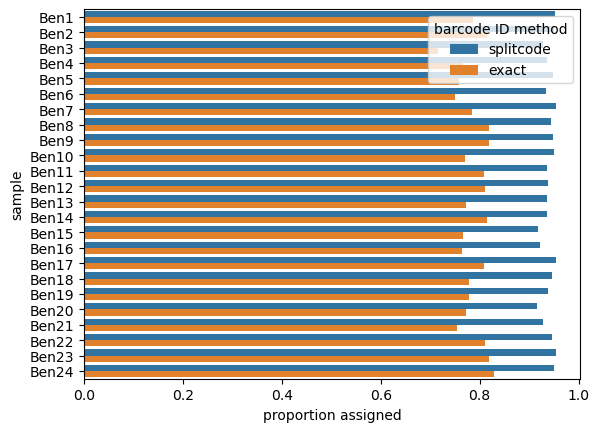

In [98]:
ax = sns.barplot(
    (
        df_data
        .drop_duplicates('sample')
        .assign(
            splitcode=df_data['n_assigned'] / df_data['n_reads'],
            exact=df_data['n_assigned_exact'] / df_data['n_reads'])
        .melt(
            id_vars='sample',
            value_vars=['splitcode', 'exact'],
            var_name='barcode ID method',
            value_name='proportion assigned'
        )
    ),
    x='proportion assigned',
    y='sample',
    hue='barcode ID method',
    # color='C0'
)
# ax.axvline(
#     x=(df_data['n_assigned'] / df_data['n_reads']).min(),
#     label='Minimum: {:.1%}'.format((df_data['n_assigned'] / df_data['n_reads']).min()),
#     color='C1'
# )
# ax.legend()
ax.figure.show()

In [112]:
print('Barcode identification statistics:', end='\n\n')
pd.concat(
    (df_data.drop_duplicates('sample').pipe(lambda df: df['n_assigned'] / df['n_reads']).describe().rename('splitcode'),
     df_data.drop_duplicates('sample').pipe(lambda df: df['n_assigned_exact'] / df['n_reads']).describe().rename('exact')),
    axis=1
)

Barcode identification statistics:



splitcode      exact
count  24.000000  24.000000
mean    0.940335   0.786214
std     0.011702   0.028761
min     0.915254   0.716643
25%     0.935259   0.766615
50%     0.941840   0.781426
75%     0.950155   0.812073
max     0.954899   0.829104

In [81]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
n_total="$(unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz | wc -l)"
n_umis="$(
    unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz |
    grep -E -e 'RX:Z:[ATCGN-]*N' |
    wc -l
)"
echo "Number of UMIs by containing Ns: $n_umis out of $n_total total assigned reads"

Number of UMIs by containing Ns: 1652 out of 7170381 total assigned reads


## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count` (deduplicated)

In [82]:
path_umi_validation = os.path.join(DIR_RESULTS, 'umi_validation.csv')
path_tag_counts = os.path.join(DIR_RESULTS, 'tag_counts.csv')
path_barcode_counts = os.path.join(DIR_RESULTS, 'barcode_counts.csv')
path_umi_ecdf = os.path.join(DIR_RESULTS, 'umi_ecdf.csv')

In [83]:
reprocess = not all(os.path.exists(path) for path in [path_umi_validation, path_tag_counts, path_barcode_counts, path_umi_ecdf])
print('reprocess:', reprocess)

reprocess: True


In [120]:
regex_barcode = re.compile((
    r'\[LigEven\]'
    r'\[R1Top_(?P<R1>\d+)\]'
    r'\[LigR1\]'
    r'\[R2Top_(?P<R2>\d+)\]'
    r'\[LigR2\]'
    r'\[R3Top_(?P<R3>\d+)\]'
    r'\[LigR3\]'
    r'\[NYLigOddStgTop_(?P<Y>\d+)\]'
    r'\[2Pbc\]'
    r'\[NYStgBot_(?P<Y_2>\d+)\]'
    r'\[R3\]'
    r'\[R3Bot_(?P<R3_2>\d+)\]'
    r'\[R2\]'
    r'\[R2Bot_(?P<R2_2>\d+)\]'
    r'\[R1\]'
    r'\[R1Bot_(?P<R1_2>\d+)\]'
    r'\[Even\]'
    r'\[2Puni\]'
    r'\s+'
    r'RX:Z:(?P<umi>[ACGNT]*)-(?P<umi_2>[ACGNT]*)'
))

DTYPE_SAMPLE = pd.api.types.CategoricalDtype(categories=list(df_data['sample'].unique()))
DTYPE_COUNT_TYPE = pd.api.types.CategoricalDtype(categories=['raw', 'dedup'])
DTYPE_ROUNDS = pd.api.types.CategoricalDtype(categories=ROUNDS)

def count_barcodes(sample, regex, path_barcodes=None):
    '''
    From the read_barcodes file generated from a given sample and splitcode config,
    count the barcodes and UMIs, and tabulate in pandas DataFrames.

    Args
    - sample: str
        Sample name
    - regex: re.Pattern
        Regular expression pattern for barcode. Should contain named capture groups.
    
    Returns
    - df_barcode_counts: pandas.DataFrame
      - Only includes reads associated with 12 bp UMIs containing no Ns
      - Columns
        - R1, R2, R3, Y: np.uint8
        - count: np.int64
        - count_dedup: np.int64
        - sample: DTYPE_SAMPLE
    - df_umi_counts: pandas.DataFrame
      - R1, R2, R2_bot, R3, Y: np.uint8
      - umi: str
      - count: np.int64
      - sample: DTYPE_SAMPLE
    - n_unmatched: int
        Number of reads whose barcodes did not match the provided regex.
    '''
    if path_barcodes is None:
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_barcodes, 'rt') as f:
        df_umi_counts, n_unmatched, unmatched = parse_barcodes.barcodes_to_df(f, regex)
    if len(df_umi_counts) > 0:
        df_umi_counts = (
            df_umi_counts
            .fillna(0)
            .astype({k: np.uint8 for k in ('R1', 'R2', 'R3', 'Y', 'R1_2', 'R2_2', 'R3_2', 'Y_2')})
            .groupby(list(df_umi_counts.columns), observed=True).size()
            .reset_index().rename(columns={0: 'count'})
        )
    else:
        df_umi_counts = pd.DataFrame([], columns=ROUNDS + ['R1_2', 'R2_2', 'R3_2', 'Y_2', 'umi', 'umi_2', 'count'])
    df_barcode_counts = (
        df_umi_counts
        .loc[
            (~df_umi_counts['umi'].str.contains('N')) & \
            (df_umi_counts['umi'].map(len) == 12) & \
            (df_umi_counts['umi'] == df_umi_counts['umi_2']) & \
            (df_umi_counts['R1'] == df_umi_counts['R1_2']) & \
            (df_umi_counts['R2'] == df_umi_counts['R2_2']) & \
            (df_umi_counts['R3'] == df_umi_counts['R3_2']) & \
            (df_umi_counts['Y'] == df_umi_counts['Y_2'])
        ]
        .drop(columns=['R1_2', 'R2_2', 'R3_2', 'Y_2', 'umi_2'])
        .groupby(ROUNDS, observed=True)["count"]
        .agg(["count", "sum"])
        .reset_index()
        .rename(columns={"count": "count_dedup", "sum": "count"})
    )
    df_barcode_counts['sample'] = pd.Series([sample] * len(df_barcode_counts), dtype=DTYPE_SAMPLE)
    df_umi_counts['sample'] = pd.Series([sample] * len(df_umi_counts), dtype=DTYPE_SAMPLE)
    return df_barcode_counts, df_umi_counts, n_unmatched, unmatched

In [121]:
def umi_df_to_validation(df, n_unmatched=None):
    '''
    Compute summary validation metrics from a UMI counts table (e.g., df_umi_counts).

    Args
    - df: pandas.DataFrame
        Columns must include 'umi' and 'count'. In this notebook, usually df_umi_counts.
    - n_unmatched: int or None
        Number of unmatched reads

    Returns: pandas.DataFrame
    - metric: str
        'R2 mismatch', 'N in UMI', or 'n_unmatched'
    - count_type: str
        'raw' or 'dedup'
    - count: int or None
    '''
    entries = []

    # reads with different R2 tag identified in read 1 versus read 2
    for r in (ROUNDS + ['umi']):
        mask_mismatch = df[r] != df[r + '_2']
        entries.append(dict(metric=f'{r} mismatch', count_type='raw', count=df.loc[mask_mismatch, 'count'].sum()))
        entries.append(dict(metric=f'{r} mismatch', count_type='dedup', count=mask_mismatch.sum()))

    # reads with UMIs containing Ns
    mask_ns = df['umi'].str.contains('N') | df['umi_2'].str.contains('N')
    entries.append(dict(metric='N in UMI', count_type='raw', count=df.loc[mask_ns, 'count'].sum()))
    entries.append(dict(metric='N in UMI', count_type='dedup', count=mask_ns.sum()))

    # reads unmatched
    entries.append(dict(metric='n_unmatched', count_type='raw', count=n_unmatched))
    return pd.DataFrame(entries)

In [86]:
if reprocess:
    df_umi_val_all = {}
    df_umi_ecdf = {}
    df_barcode_counts_all = {}

In [88]:
if reprocess:
    for sample in df_data['sample'].unique():
        df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(sample, regex_barcode)
        if n_unmatched > 0:
            print((
                f'Sample {sample}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                f'the regex. {min(3, n_unmatched)} / {n_unmatched} unmatched barcode-appended '
                'read names are printed below:'))
            for i in range(min(3, n_unmatched)):
                print('-', unmatched[i])
        df_umi_val_all[sample] = umi_df_to_validation(df_umi_counts, n_unmatched).assign(sample=sample)
        df_umi_ecdf[sample] = df_umi_counts['count'].value_counts()
        df_barcode_counts_all[sample] = df_barcode_counts.assign(sample=sample).astype(dict(sample=DTYPE_SAMPLE))

### Save / Load Processed Data

In [89]:
if reprocess:
    df_umi_val_all = pd.concat(df_umi_val_all.values(), axis=0, ignore_index=True)
    df_umi_val_all.to_csv(path_umi_validation, index=False)
else:
    df_umi_val_all = pd.read_csv(path_umi_validation, index_col=False)

In [90]:
if reprocess:
    df_barcode_counts_all = pd.concat(df_barcode_counts_all.values(), axis=0, ignore_index=True)
    df_barcode_counts_all.to_csv(path_barcode_counts, index=False)
else:
    df_barcode_counts_all = pd.read_csv(
        path_barcode_counts,
        dtype={
            'R1': np.uint8,
            'R2': np.uint8,
            'R3': np.uint8,
            'Y': np.uint8,
            'count': np.int64,
            'count_dedup': np.int64,
            'sample': DTYPE_SAMPLE,
            'count_type': DTYPE_COUNT_TYPE,
        },
        index_col=False
    )

In [132]:
if reprocess:
    df_umi_ecdf_long = (
        pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf.values()), axis=1)
        .fillna(0)
        .astype(int)
        .sort_index()
        .reset_index(names='count')
        .melt(id_vars='count', var_name='sample', value_name='frequency')
        .groupby('sample', group_keys=False)
        .apply(lambda g: (
            g.sort_values('count')
            .pipe(lambda g2: g.assign(cumulative_prop=g['frequency'].cumsum() / g['frequency'].sum()))
        ))
        .pipe(lambda df: df.assign(sample=df['sample'].map(lambda i: list(df_umi_ecdf.keys())[i])))
    )
    df_umi_ecdf_long.to_csv(path_umi_ecdf, index=False)
else:
    df_umi_ecdf_long = pd.read_csv(path_umi_ecdf, index_col=False)

In [92]:
if reprocess:
    df_tag_counts = (
        df_barcode_counts_all
        .rename(columns=dict(count='raw', count_dedup='dedup'))
        .melt(
            id_vars=ROUNDS + ['sample'],
            var_name='count_type',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(round=DTYPE_ROUNDS))
    )
    df_tag_counts.to_csv(path_tag_counts, index=False)
else:
    df_tag_counts = pd.read_csv(
        path_tag_counts,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            round=DTYPE_ROUNDS
        )
    )

# Validation

All assigned reads had read structures and UMIs matching expected regex.

In [93]:
df_umi_val_all.loc[df_umi_val_all['metric'] == 'n_unmatched', 'count'].unique()

array([0])

A negligible proportion of reads have different tags identified in read 1 vs. read 2, but there was a more sizeable proportion (up to ~2.5%) of reads with different UMIs identified in read 1 vs. read 2.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



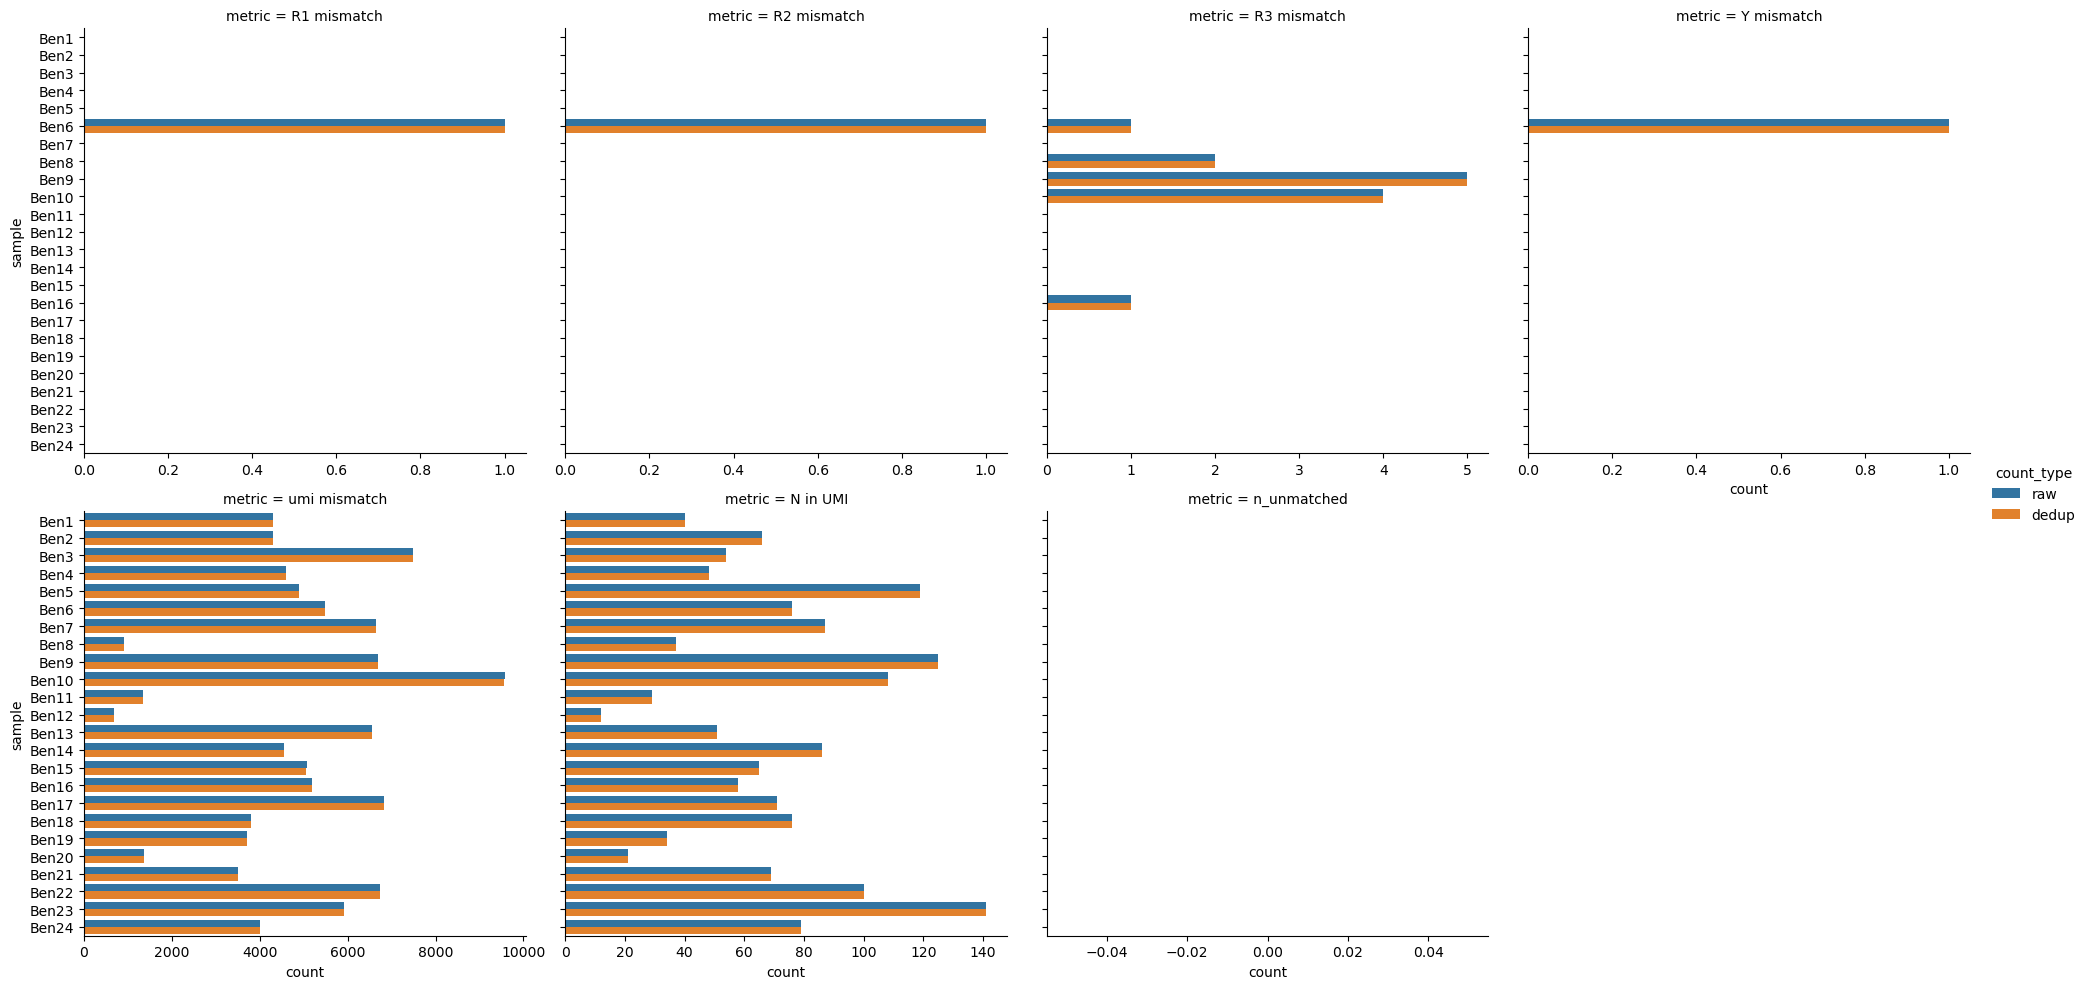

In [95]:
g = sns.catplot(
    kind='bar',
    data=df_umi_val_all,
    x='count',
    y='sample',
    hue='count_type',
    col='metric',
    col_wrap=4,
    sharex=False
)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



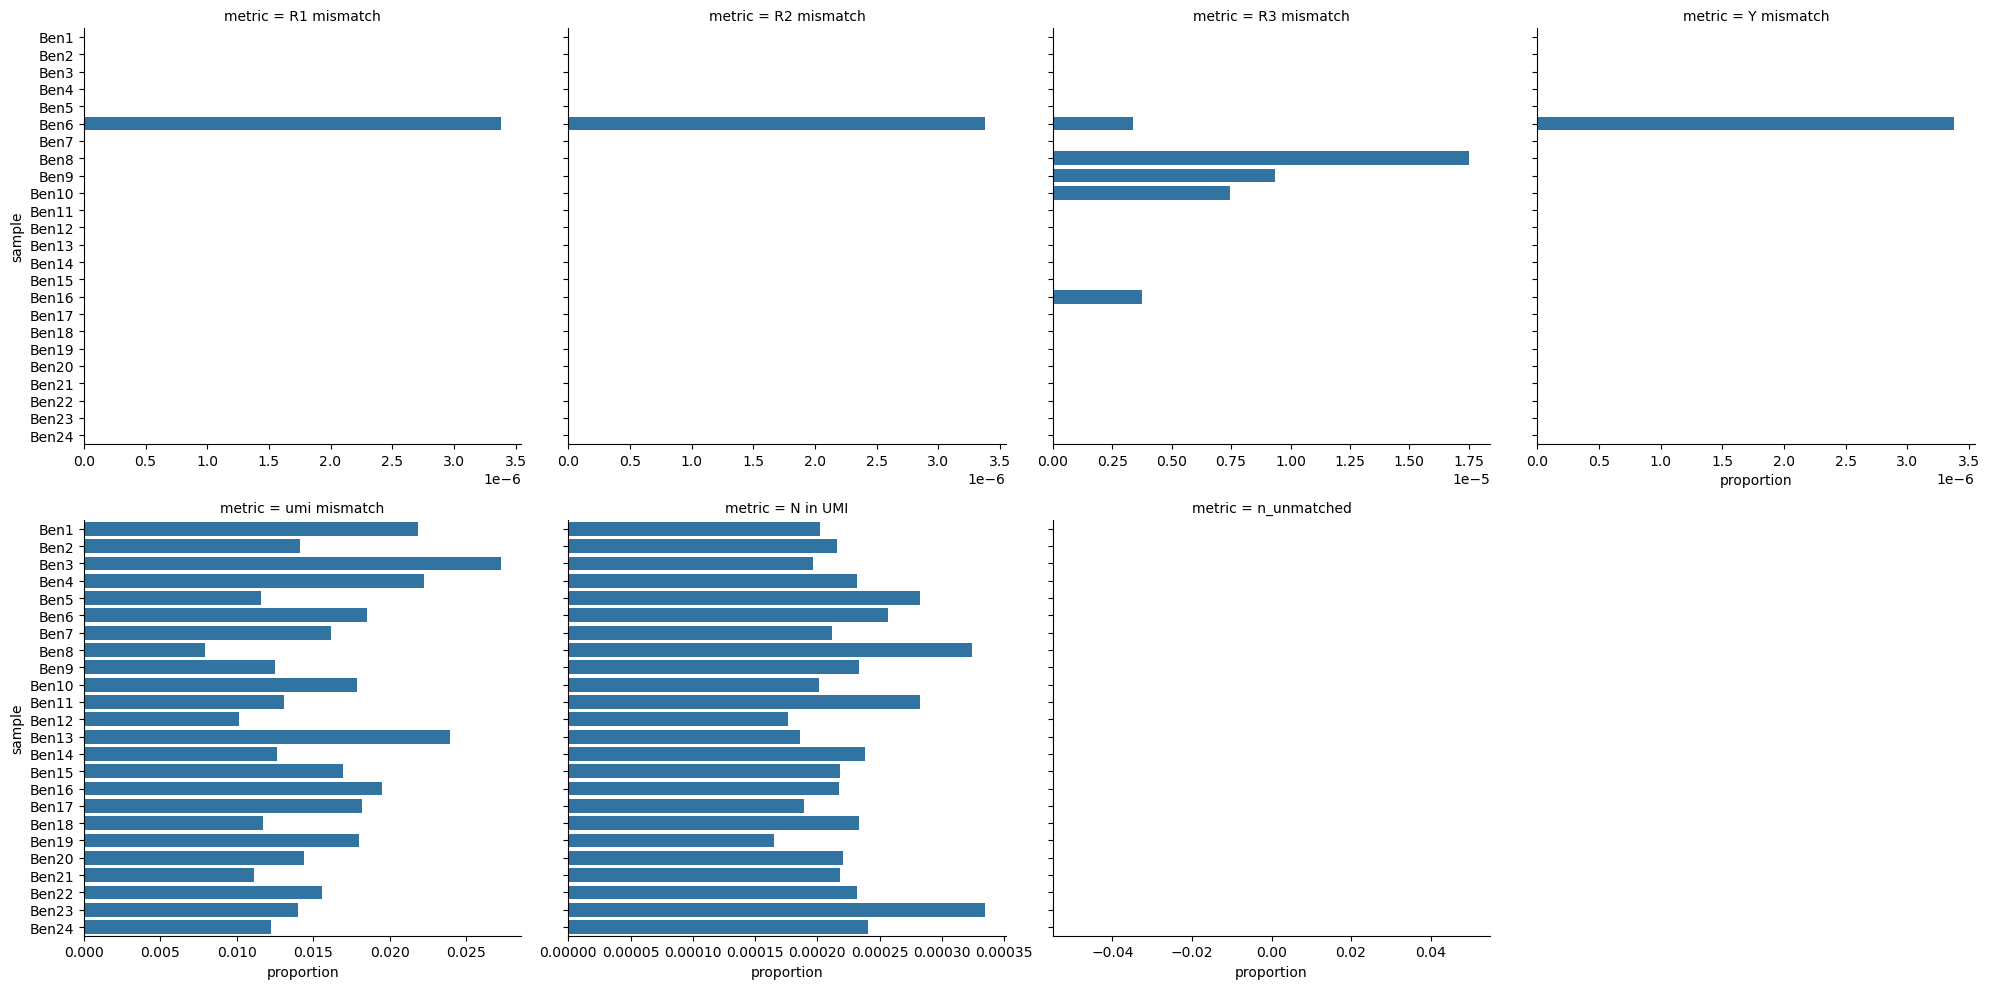

In [96]:
g = sns.catplot(
    kind='bar',
    data=(
        df_umi_val_all
        .loc[df_umi_val_all['count_type'] == 'raw']
        .drop(columns='count_type')
        .merge(df_data[['sample', 'n_assigned']].drop_duplicates('sample'))
        .pipe(lambda df: df.assign(proportion=df['count'] / df['n_assigned']))
        [['metric', 'sample', 'proportion']]
    ),
    x='proportion',
    y='sample',
    col='metric',
    col_wrap=4,
    color='C0',
    sharex=False
)

# Ligation QC

Tag counts faceted by sample and round, grouped (colored) by count type (raw or deduplicated)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



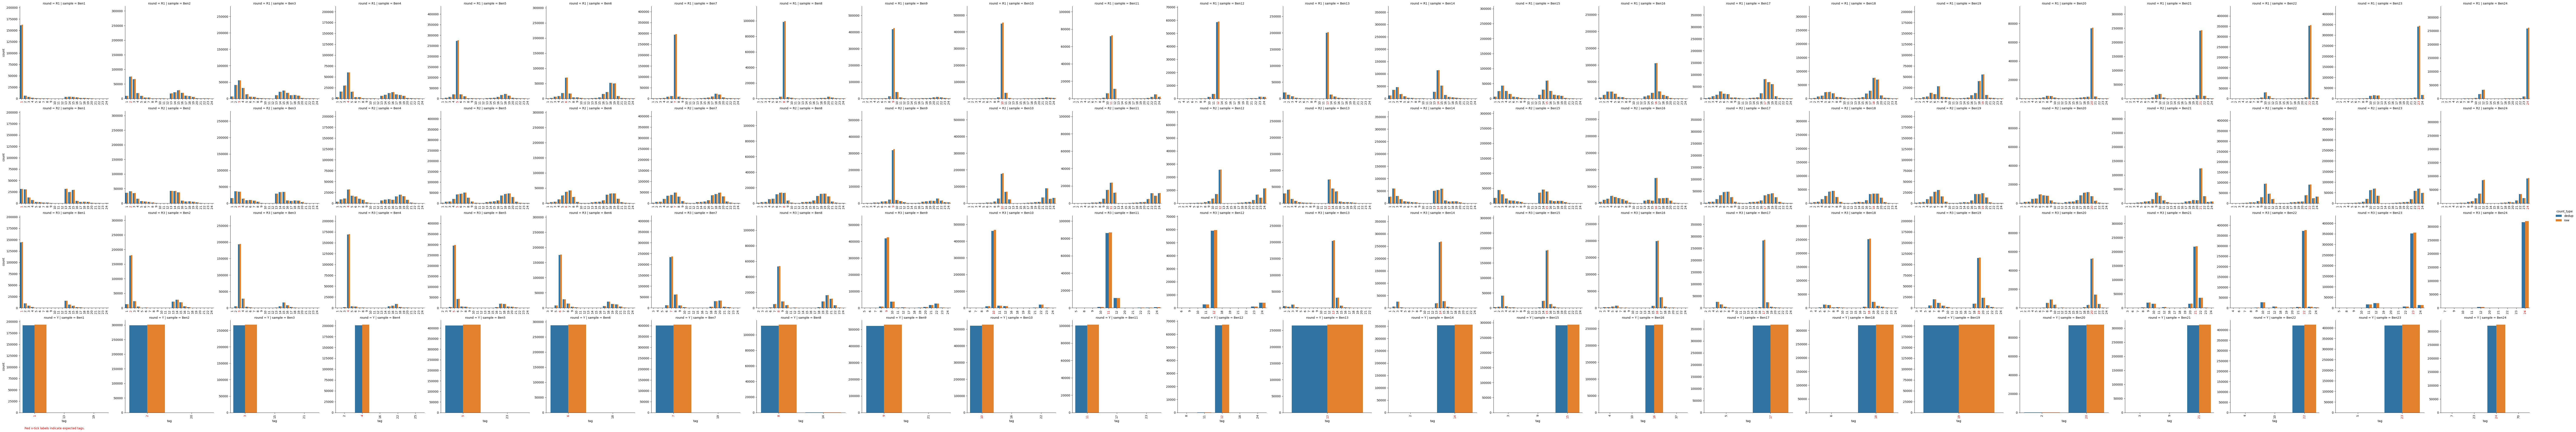

In [97]:
g = sns.catplot(
    df_tag_counts,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to expected tag
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) == df_data.loc[df_data['sample'] == sample, 'well'].iloc[0]:
            text.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate expected tags.',
    color='red',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [98]:
for sample in df_barcode_counts_all['sample'].unique():
    mask_sample = (df_barcode_counts_all['sample'] == sample)
    fig = go.Figure(go.Parcats(
        dimensions=[
            {
                'label': r,
                'values': df_barcode_counts_all.loc[mask_sample, r],
                'categoryorder': 'category ascending'
            } for r in ROUNDS
        ],
        counts=df_barcode_counts_all.loc[mask_sample, 'count_dedup']))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    # fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_{sample}.pdf'))

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [117]:
fig = px.line(
    (
        df_barcode_counts_all
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .merge(df_data[['sample', 'well']], how='left')
        .melt(id_vars=['sample', 'rank', 'well'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='well',
    facet_row='metric',
    markers=True,
    category_orders=dict(well=sorted(df_data['well'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['well'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'), scale=2)
fig.show()

# Sequencing Depth and Duplicates

## UMI distribution

In [135]:
umi_distribution = (
    df_umi_ecdf_long.groupby('count')['frequency'].sum()
    .pipe(lambda s: s/s.sum()).rename('proportion')
)
display(umi_distribution)
print('mean UMI count: {:.3f}'.format((np.array(umi_distribution.index) * umi_distribution).sum()))

count
0    0.000000e+00
1    9.907629e-01
2    9.155743e-03
3    8.051603e-05
4    8.445738e-07
Name: proportion, dtype: float64

mean UMI count: 1.009


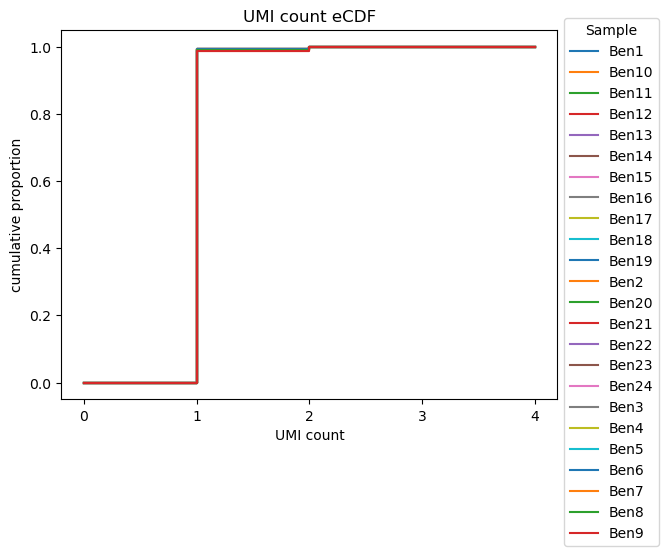

In [145]:
fig, ax = plt.subplots()
for sample in sorted(df_umi_ecdf_long['sample'].unique()):
    mask = (df_umi_ecdf_long['sample'] == sample)
    ax.step(
        df_umi_ecdf_long.loc[mask, 'count'],
        df_umi_ecdf_long.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(xlabel='UMI count', ylabel='cumulative proportion', title='UMI count eCDF', xticks=range(df_umi_ecdf_long['count'].max() + 1))
fig.show()

## Estimate library complexity

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [138]:
def estimate_library_complexity(count_total, count_dedup, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, such that count_dedup molecules were sampled at least once. Solve
    for M.
    '''
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, count_total*1e5)
    )
    assert res.fun < max_err
    return res.x

In [147]:
umi_complexity = 4**12
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 16777216


Calculate the complexity of all barcodes in each sample.

In [148]:
complexity_umi_all = df_barcode_counts_all.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

Calculate the complexity of the predominant barcode in each sample.

In [149]:
complexity_umi_top = (
    df_barcode_counts_all
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.iloc[group["count"].argmax()][["count", "count_dedup"]])
    .apply(lambda s: estimate_library_complexity(s['count'], s['count_dedup']), axis=1)
)

### Plot

<span style="color:red">Complexity estimated by Tapestation is >5 orders of magnitude greater than complexity estimated by sequencing.</span>

In [150]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename('complexity_umi_est_top'),
            complexity_umi_all.rename('complexity_umi_est_all'),
            
        ),
        axis=1,
    ).reset_index(),
    how='left'
)

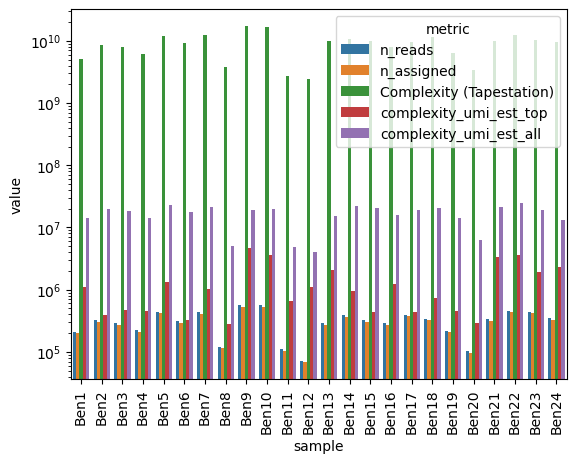

In [151]:
ax = sns.barplot(
    (
        df_data
        [['sample', 'n_reads', 'n_assigned', 'Complexity (Tapestation)', 'complexity_umi_est_top', 'complexity_umi_est_all']]
        .drop_duplicates()
        .melt(id_vars='sample')
        .rename(columns={'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
ax.figure.show()

## Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `Complexity (Tapestation)` molecules.

In [152]:
(
    df_data[['sample', 'n_assigned', 'Complexity (Tapestation)']]
    .drop_duplicates()
    .apply(
        lambda s: 1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['Complexity (Tapestation)']),
        axis=1
    )
    .rename('coverage')
)

0     0.000038
2     0.000035
4     0.000034
6     0.000034
8     0.000035
10    0.000032
12    0.000034
14    0.000031
16    0.000031
18    0.000032
20    0.000038
22    0.000028
24    0.000027
26    0.000034
28    0.000030
30    0.000033
32    0.000039
34    0.000029
36    0.000032
38    0.000028
40    0.000032
42    0.000035
44    0.000041
46    0.000034
Name: coverage, dtype: float64

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [153]:
(
    df_barcode_counts_all[['sample', 'count', 'count_dedup']]
    .groupby(['sample']).sum()
    .pipe(lambda df: df.assign(duplication_rate=(df['count'] - df['count_dedup'])/df['count']))
)

count  count_dedup  duplication_rate
sample                                       
Ben1    193364       192042          0.006837
Ben2    301113       298811          0.007645
Ben3    267563       265612          0.007292
Ben4    202491       201027          0.007230
Ben5    416454       412692          0.009033
Ben6    290545       288200          0.008071
Ben7    404460       400658          0.009400
Ben8    113196       111923          0.011246
Ben9    528861       521500          0.013919
Ben10   526993       520121          0.013040
Ben11   101280       100219          0.010476
Ben12    67392        66833          0.008295
Ben13   267464       265172          0.008569
Ben14   356083       353223          0.008032
Ben15   293414       291307          0.007181
Ben16   261881       259703          0.008317
Ben17   368230       364699          0.009589
Ben18   321375       318866          0.007807
Ben19   202507       201044          0.007224
Ben20    93789        93084          0.007517
Ben21   312459       310164          0.007345
Ben22   425331       421674          0.008598
Ben23   415516       411039          0.010775
Ben24   324449       320424          0.012406

# Compare with exact matching

## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count` (deduplicated)

In [114]:
path_umi_validation_exact = os.path.join(DIR_RESULTS, 'umi_validation_exact.csv')
path_tag_counts_exact = os.path.join(DIR_RESULTS, 'tag_counts_exact.csv')
path_barcode_counts_exact = os.path.join(DIR_RESULTS, 'barcode_counts_exact.csv')
path_umi_ecdf_exact = os.path.join(DIR_RESULTS, 'umi_ecdf_exact.csv')

In [115]:
reprocess = not all(os.path.exists(path) for path in [path_umi_validation_exact, path_tag_counts_exact, path_barcode_counts_exact, path_umi_ecdf_exact])
print('reprocess:', reprocess)

reprocess: True


In [116]:
if reprocess:
    df_umi_val_all_exact = {}
    df_umi_ecdf_exact = {}
    df_barcode_counts_all_exact = {}

In [122]:
if reprocess:
    for sample in df_data['sample'].unique():
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
        df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(sample, regex_barcode, path_barcodes)
        if n_unmatched > 0:
            print((
                f'Sample {sample}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                f'the regex. {min(3, n_unmatched)} / {n_unmatched} unmatched barcode-appended '
                'read names are printed below:'))
            for i in range(min(3, n_unmatched)):
                print('-', unmatched[i])
        df_umi_val_all_exact[sample] = umi_df_to_validation(df_umi_counts, n_unmatched).assign(sample=sample)
        df_umi_ecdf_exact[sample] = df_umi_counts['count'].value_counts()
        df_barcode_counts_all_exact[sample] = df_barcode_counts.assign(sample=sample).astype(dict(sample=DTYPE_SAMPLE))

### Save / Load Processed Data

In [123]:
if reprocess:
    df_umi_val_all_exact = pd.concat(df_umi_val_all_exact.values(), axis=0, ignore_index=True)
    df_umi_val_all_exact.to_csv(path_umi_validation_exact, index=False)
else:
    df_umi_val_all_exact = pd.read_csv(path_umi_validation_exact, index_col=False)

In [124]:
if reprocess:
    df_barcode_counts_all_exact = pd.concat(df_barcode_counts_all_exact.values(), axis=0, ignore_index=True)
    df_barcode_counts_all_exact.to_csv(path_barcode_counts_exact, index=False)
else:
    df_barcode_counts_all_exact = pd.read_csv(
        path_barcode_counts_exact,
        dtype={
            'R1': np.uint8,
            'R2': np.uint8,
            'R3': np.uint8,
            'Y': np.uint8,
            'count': np.int64,
            'count_dedup': np.int64,
            'sample': DTYPE_SAMPLE,
            'count_type': DTYPE_COUNT_TYPE,
        },
        index_col=False
    )

In [125]:
if reprocess:
    df_umi_ecdf_long_exact = (
        pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf_exact.values()), axis=1)
        .fillna(0)
        .astype(int)
        .sort_index()
        .reset_index(names='count')
        .melt(id_vars='count', var_name='sample', value_name='frequency')
        .groupby('sample', group_keys=False)
        .apply(lambda g: (
            g.sort_values('count')
            .pipe(lambda g2: g.assign(cumulative_prop=g['frequency'].cumsum() / g['frequency'].sum()))
        ))
        .pipe(lambda df: df.assign(sample=df['sample'].map(lambda i: list(df_umi_ecdf_exact.keys())[i])))
    )
    df_umi_ecdf_long_exact.to_csv(path_umi_ecdf_exact, index=False)
else:
    df_umi_ecdf_long_exact = pd.read_csv(path_umi_ecdf_exact, index_col=False)

In [126]:
if reprocess:
    df_tag_counts_exact = (
        df_barcode_counts_all_exact
        .rename(columns=dict(count='raw', count_dedup='dedup'))
        .melt(
            id_vars=ROUNDS + ['sample'],
            var_name='count_type',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(round=DTYPE_ROUNDS))
    )
    df_tag_counts_exact.to_csv(path_tag_counts_exact, index=False)
else:
    df_tag_counts_exact = pd.read_csv(
        path_tag_counts_exact,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            round=DTYPE_ROUNDS
        )
    )

# Validation

All assigned reads had read structures and UMIs matching expected regex.

In [127]:
df_umi_val_all_exact.loc[df_umi_val_all_exact['metric'] == 'n_unmatched', 'count'].unique()

array([0])

A negligible proportion of reads have different tags identified in read 1 vs. read 2, but there was a more sizeable proportion (up to ~2.5%) of reads with different UMIs identified in read 1 vs. read 2.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



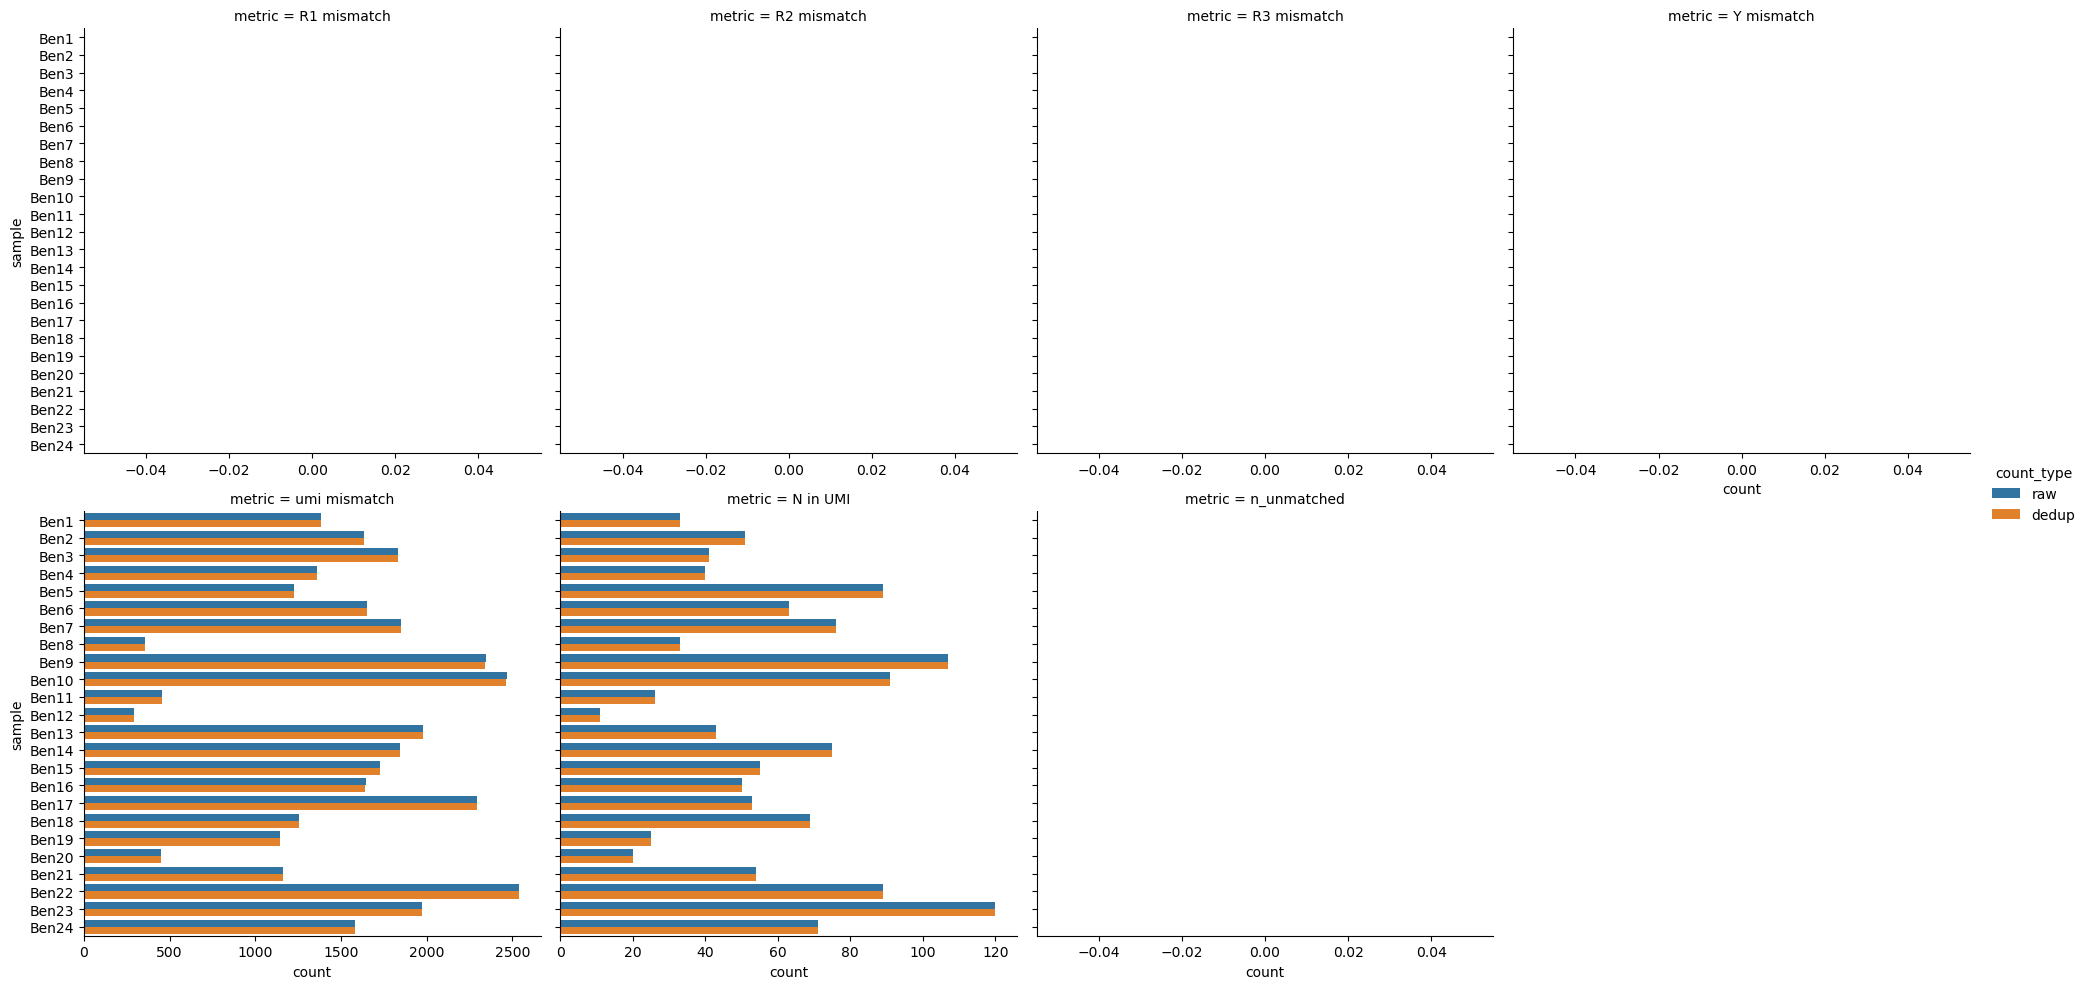

In [128]:
g = sns.catplot(
    kind='bar',
    data=df_umi_val_all_exact,
    x='count',
    y='sample',
    hue='count_type',
    col='metric',
    col_wrap=4,
    sharex=False
)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



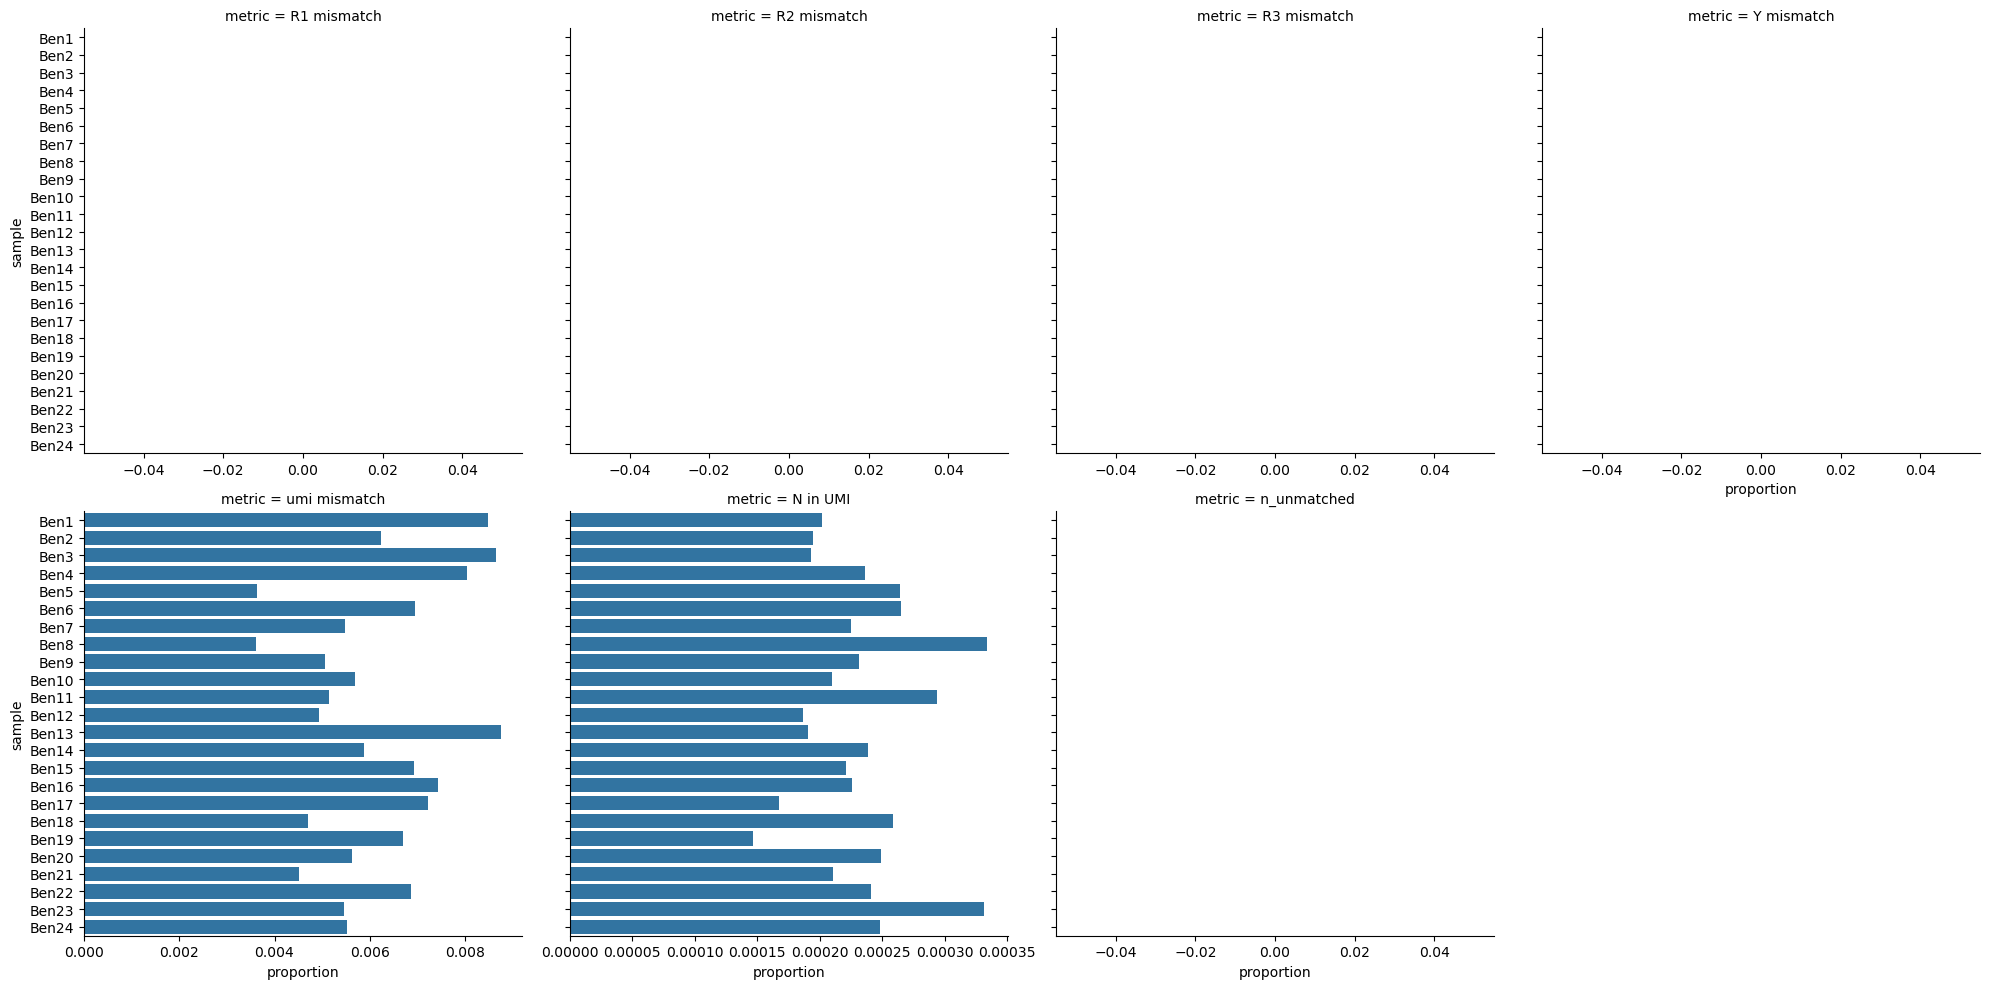

In [132]:
g = sns.catplot(
    kind='bar',
    data=(
        df_umi_val_all_exact
        .loc[df_umi_val_all_exact['count_type'] == 'raw']
        .drop(columns='count_type')
        .merge(df_data[['sample', 'n_assigned_exact']].drop_duplicates('sample'))
        .pipe(lambda df: df.assign(proportion=df['count'] / df['n_assigned_exact']))
        [['metric', 'sample', 'proportion']]
    ),
    x='proportion',
    y='sample',
    col='metric',
    col_wrap=4,
    color='C0',
    sharex=False
)

# Ligation QC

Tag counts faceted by sample and round, grouped (colored) by count type (raw or deduplicated)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



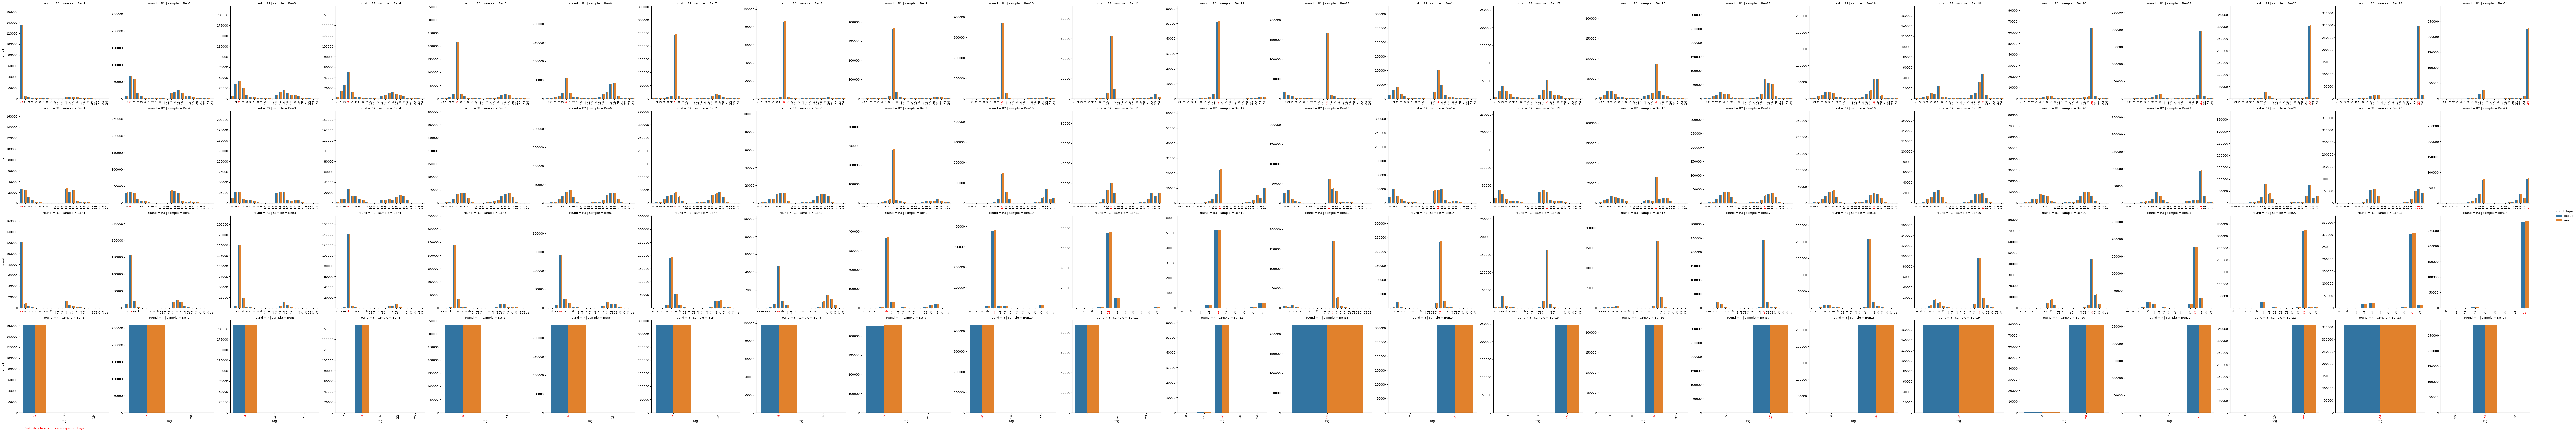

In [130]:
g = sns.catplot(
    df_tag_counts_exact,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to expected tag
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) == df_data.loc[df_data['sample'] == sample, 'well'].iloc[0]:
            text.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate expected tags.',
    color='red',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample_exact.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [133]:
for sample in df_barcode_counts_all_exact['sample'].unique():
    mask_sample = (df_barcode_counts_all_exact['sample'] == sample)
    fig = go.Figure(go.Parcats(
        dimensions=[
            {
                'label': r,
                'values': df_barcode_counts_all_exact.loc[mask_sample, r],
                'categoryorder': 'category ascending'
            } for r in ROUNDS
        ],
        counts=df_barcode_counts_all_exact.loc[mask_sample, 'count_dedup']))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    # fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_exact_{sample}.pdf'))

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [134]:
fig = px.line(
    (
        df_barcode_counts_all_exact
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .merge(df_data[['sample', 'well']], how='left')
        .melt(id_vars=['sample', 'rank', 'well'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='well',
    facet_row='metric',
    markers=True,
    category_orders=dict(well=sorted(df_data['well'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['well'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank_exact.png'), scale=2)
fig.show()

# Sequencing Depth and Duplicates

## UMI distribution

In [135]:
umi_distribution_exact = (
    df_umi_ecdf_long_exact.groupby('count')['frequency'].sum()
    .pipe(lambda s: s/s.sum()).rename('proportion')
)
display(umi_distribution_exact)
print('mean UMI count: {:.3f}'.format((np.array(umi_distribution_exact.index) * umi_distribution_exact).sum()))

count
0    0.000000e+00
1    9.923374e-01
2    7.606906e-03
3    5.523722e-05
4    5.052185e-07
Name: proportion, dtype: float64

mean UMI count: 1.008


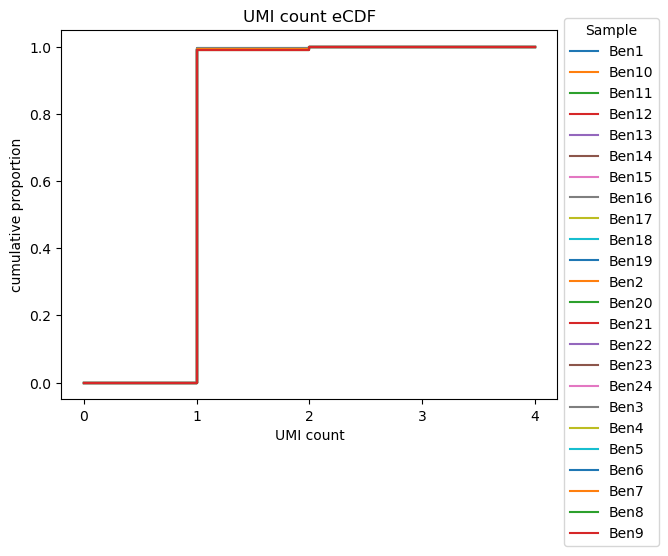

In [136]:
fig, ax = plt.subplots()
for sample in sorted(df_umi_ecdf_long_exact['sample'].unique()):
    mask = (df_umi_ecdf_long_exact['sample'] == sample)
    ax.step(
        df_umi_ecdf_long_exact.loc[mask, 'count'],
        df_umi_ecdf_long_exact.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(xlabel='UMI count', ylabel='cumulative proportion', title='UMI count eCDF', xticks=range(df_umi_ecdf_long_exact['count'].max() + 1))
fig.show()

## Estimate library complexity

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

Calculate the complexity of all barcodes in each sample.

In [139]:
complexity_umi_all_exact = df_barcode_counts_all_exact.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

Calculate the complexity of the predominant barcode in each sample.

In [140]:
complexity_umi_top_exact = (
    df_barcode_counts_all_exact
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.iloc[group["count"].argmax()][["count", "count_dedup"]])
    .apply(lambda s: estimate_library_complexity(s['count'], s['count_dedup']), axis=1)
)

### Plot

<span style="color:red">Complexity estimated by Tapestation is >5 orders of magnitude greater than complexity estimated by sequencing.</span>

In [141]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top_exact.rename('complexity_umi_est_top_exact'),
            complexity_umi_all_exact.rename('complexity_umi_est_all_exact'),
            
        ),
        axis=1,
    ).reset_index(),
    how='left'
)

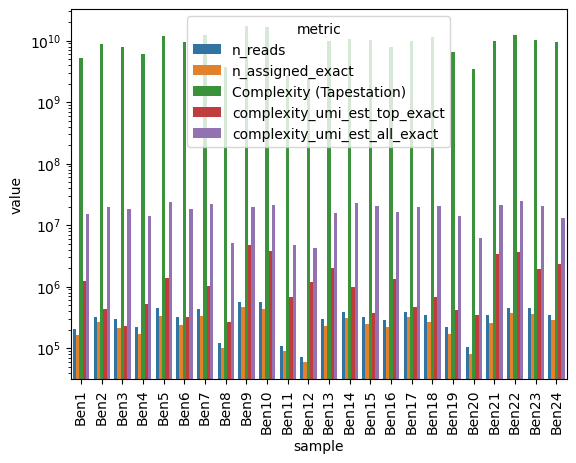

In [143]:
ax = sns.barplot(
    (
        df_data
        [['sample', 'n_reads', 'n_assigned_exact', 'Complexity (Tapestation)', 'complexity_umi_est_top_exact', 'complexity_umi_est_all_exact']]
        .drop_duplicates()
        .melt(id_vars='sample')
        .rename(columns={'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
ax.figure.show()

## Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `Complexity (Tapestation)` molecules.

In [144]:
(
    df_data[['sample', 'n_assigned_exact', 'Complexity (Tapestation)']]
    .drop_duplicates()
    .apply(
        lambda s: 1 - scipy.stats.binom.pmf(0, n=s['n_assigned_exact'], p=1/s['Complexity (Tapestation)']),
        axis=1
    )
    .rename('coverage')
)

0     0.000032
2     0.000030
4     0.000026
6     0.000028
8     0.000028
10    0.000025
12    0.000028
14    0.000027
16    0.000027
18    0.000026
20    0.000033
22    0.000025
24    0.000023
26    0.000030
28    0.000025
30    0.000028
32    0.000033
34    0.000023
36    0.000027
38    0.000024
40    0.000026
42    0.000030
44    0.000036
46    0.000030
Name: coverage, dtype: float64

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [145]:
(
    df_barcode_counts_all_exact[['sample', 'count', 'count_dedup']]
    .groupby(['sample']).sum()
    .pipe(lambda df: df.assign(duplication_rate=(df['count'] - df['count_dedup'])/df['count']))
)

count  count_dedup  duplication_rate
sample                                       
Ben1    161944       161068          0.005409
Ben2    260398       258702          0.006513
Ben3    210447       209259          0.005645
Ben4    168031       167050          0.005838
Ben5    335615       333252          0.007041
Ben6    235938       234438          0.006358
Ben7    335839       333274          0.007638
Ben8     98510        97560          0.009644
Ben9    460066       454647          0.011779
Ben10   431700       427411          0.009935
Ben11    88071        87257          0.009243
Ben12    58626        58223          0.006874
Ben13   224033       222473          0.006963
Ben14   312225       310124          0.006729
Ben15   247560       246066          0.006035
Ben16   219655       218186          0.006688
Ben17   315182       312667          0.007980
Ben18   265972       264279          0.006365
Ben19   169792       168765          0.006049
Ben20    79832        79323          0.006376
Ben21   255420       253920          0.005873
Ben22   367424       364709          0.007389
Ben23   360204       357044          0.008773
Ben24   284931       281892          0.010666